In [115]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Abstract

This blog post explores the implementation of the perceptron algorithm in Python exploring both the standard and mini-batch versions of perceptron. We demonstrate how the algorithm iteratively adjusts the weight vector to reduce misclassifications by updating based on individual data points or averaged contributions from mini-batches. We discuss how and why our implementation works, demonstrate its capacities, and discuss parameter tuning and time complexity. Notably, we show the performance of the algorithm on linearly separable and non-linearly separable data. Through this post, I expanded my understanding of how basic learning algorithms work behind the scenes for  classification purposes.

# Implementation

In [`perceptron.py`](https://github.com/lawolff1702/lawolff1702.github.io/blob/9deacaec063f8c0fe40ae8cff36eb517f0f4829d/posts/Implementing%20the%20Perceptron%20Algorithm/perceptron.py), we implement the perceptron algorithm. The `.score()`, `.loss()` and `.step()` methods are pretty intuitive. The `.grad()` (Gradient Descent) I will address in further depth. The goal of perceptron is to adjust our weights `w` so that we push our line in the right direction to minimize our loss function. In other words, push our line in a direction that reduces the number of points we misclassify at each update. We do so with respect to a single point. We randomly select a point (or a set of points in mini-batch then average them) then see if it is misclassified, we push our weights `w` closer to classifying that point correctly. This push can be scaled the the learning rate, which is `1` by default, smaller values will make smaller jumps.

Some important highlights in the code are:

- `self.score(X) * y_` computes a score for a given point that is positive when we accurately classify a point
- `(( ... < 0 ) * y_)` is an indicator random variable that will only add to our weights when we find a misclassified point, otherwise our binary encoding will nullify the rest of the term.
- `.unsqueeze(1) * X` Allows for us to use mini-batches and not encounter size broadcasting errors with matrices and vectors in PyTorch.

Our actual update happens in the `.step()` method completing the implementation.

For the first part of the analysis we will be using a default batch size of `k = 1` and learning rate of `1` which is the default perceptron algorithm as opposed to mini-batch perceptron that we will explore later.

Below we are using Professor Chodrow's [functions](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration) to generate and visualize linearly separable data to test our implementation.

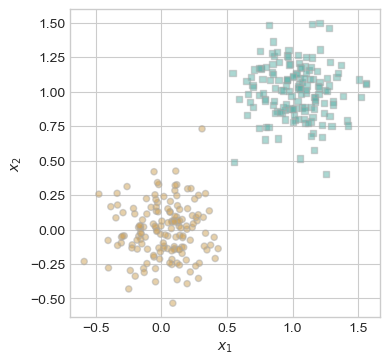

In [116]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

As we can observe we have generated a set of linearly separable data that our perceptron should be able to separate with 100% accuracy (equivalent to 0 loss)

In [117]:
from perceptron import Perceptron, PerceptronOptimizer

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y)
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

loss

tensor(0.)

Great! It worked, we have a perceptron that minimizes our loss to zero! We can see below the step by step process as the perceptron algorithm iteratively finds the line that separates the squares and the circles.

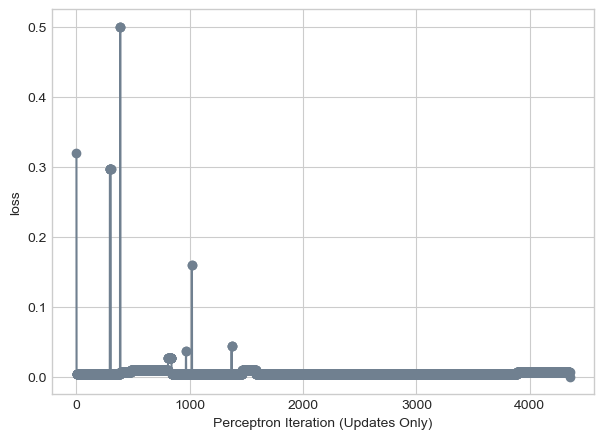

In [118]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Here is the line we found:

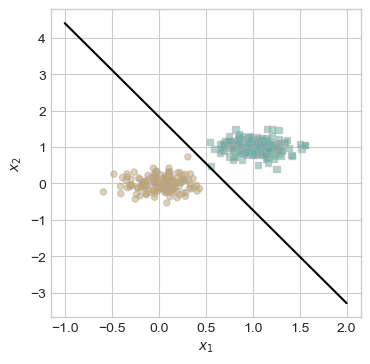

In [119]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")

# Experiments

Let us delve into how we arrived to this line iteratively on two dimensional data. First, we are going to have a look at a situation where we know our data is *linearly separable*. We are going to explore this with a slightly modified function from the [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration). This skeleton implements the iterative aspect of perceptron. We loop our code until we have reached a loss score of 0 (separated the two clusters). Within each loop, we choose a point at random and find the loss score of that point given our current line. Then depending on whether or not we correctly classified it using our current line, we shift the line in the direction that would lead to correctly classifying that point. We do this, again, until our overall loss is zero.

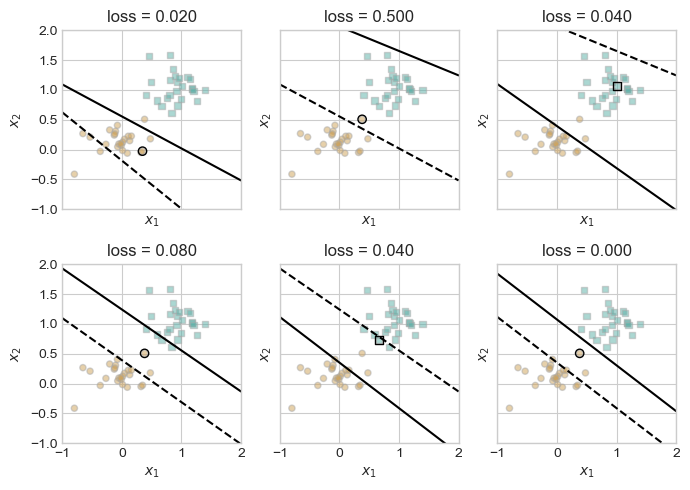

In [120]:
torch.manual_seed(3141)
X, y = perceptron_data(n_points=50, noise=0.3)
n = X.shape[0]

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

plot_data = []
loss_vec = []

loss = 1
while loss > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)
        plot_data.append((old_w, torch.clone(p.w), i, loss))


plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex=True, sharey=True)
markers = ["o", ","]
marker_map = {-1: 0, 1: 1}

plot_data = plot_data[-6:]

for current_ax, (old_w, new_w, i, loss) in enumerate(plot_data):
    ax = axarr.ravel()[current_ax]
    plot_perceptron_data(X, y, ax)
    draw_line(old_w, x_min=-1, x_max=2, ax=ax, color="black", linestyle="dashed")
    draw_line(new_w, x_min=-1, x_max=2, ax=ax, color="black")
    ax.scatter(X[i, 0], X[i, 1], color="black", facecolors="none", edgecolors="black", 
               marker=markers[marker_map[2 * (y[i].item()) - 1]])
    ax.set_title(f"loss = {loss:.3f}")
    ax.set(xlim=(-1, 2), ylim=(-1, 2))

plt.tight_layout()

The above figure shows the last six iterations of the perceptron as it is adjusts the weights based on local loss on data that we know is linearly separable. What is interesting to not here is that the line is not narrowly converging towards a loss of zero but rather, adjusts for each point without respect to the whole. The result of this method is that our loss seemingly jumps around in directions that may seem counter intuitive until we reach our loss of zero and terminate.

The graph below illustrates this quite well:

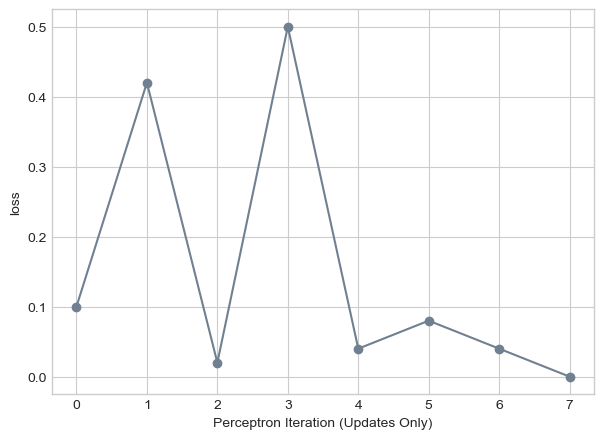

In [121]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

This is all nice and dandy when we have access to linearly separable data, but what about when our data is **not** linearly separable. In such a case, it is impossible to have a loss of zero. So we will implement a maximum number of iterations so that our code doesn't run forever to no avail.

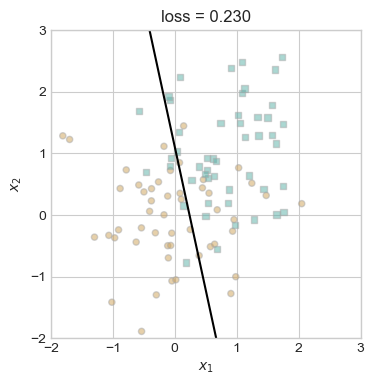

In [122]:
torch.manual_seed(124816)
X, y = perceptron_data(n_points=100, noise=0.8)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000 # Maximum number of iterations
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

In the figure above we can observe first that our data is not linearly separable, and thus even after 1000 iterations we achieved a loss score that is not terrible, but not zero.

Below we can see the evolution of the loss over these iterations, and note that there is not point with loss zero.

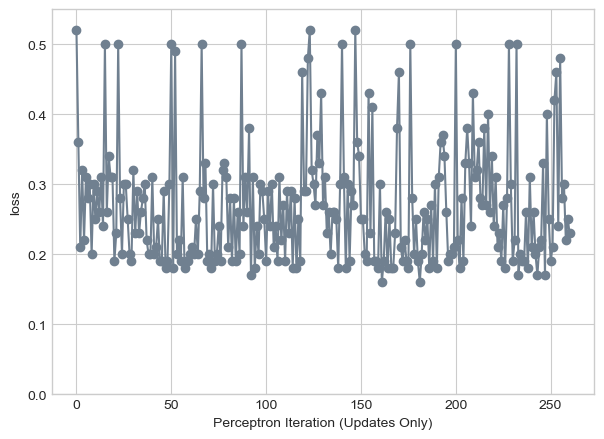

In [123]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, 0.55)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

With non linearly separable data we can also see that in some cases our loss can be above 50% misclassified for certain lines. In addition, our final iteration was not a representation of the best we could get, rather where we were after 1000 iterations. We can see that in earlier updates we achieved closer to 15% misclassified.

Thus far we have only been working with two dimensional data, however the perceptron algorithm works with higher dimensional data! Below we are going to run the algorithm on a data set with seven dimensions and observe the evolution of the loss as we iterate.

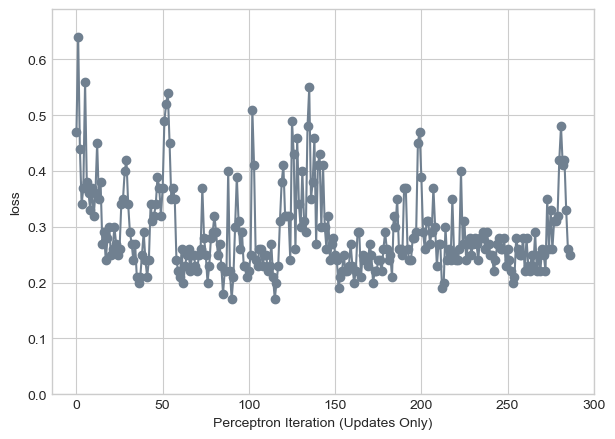

In [124]:
torch.manual_seed(2003)
X, y = perceptron_data(n_points=100, noise=1.72, p_dims=7)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000 # Maximum number of iterations
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, max(loss_vec) + 0.05)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We can see that over 1000 iterations our loss never reached zero. We can also note somewhat of a plateau of points around 0.25 that we would lead me to believe that the data is not linearly separable. We can have linearly separable data in seven dimensions as illustrated below. I chose seven because I like the number 7...

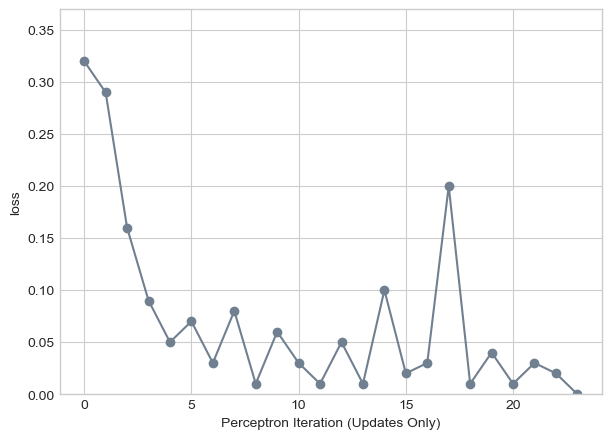

In [125]:
torch.manual_seed(2003)
X, y = perceptron_data(n_points=100, noise=0.5, p_dims=7)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

max_iter = 1000
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.ylim(0, max(loss_vec) + 0.05)
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

As we can see, in the end we do achieve a loss score of zero indicating we can accurately separate and classify the different sorts of points with a hyperplane of sorts in $\mathbb{R}^7$. This data was achieved by simply turning down the noise parameter when we generate points.

# Minibatch Perceptron

Here we implement the mini-batch perceptron algorithm that computes each update using $k$ random points at once.

We begin with a `k = 1` that performs similar to regular perceptron.

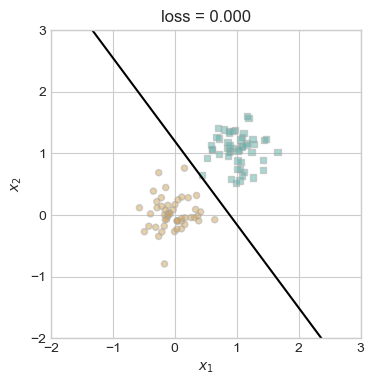

In [126]:
torch.manual_seed(6791)
X, y = perceptron_data(n_points=100, noise=0.25)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

k=1

max_iter = 1000
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i, k)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

We separate the two clusters just as we would in regular perceptron, and achieve a zero loss score.

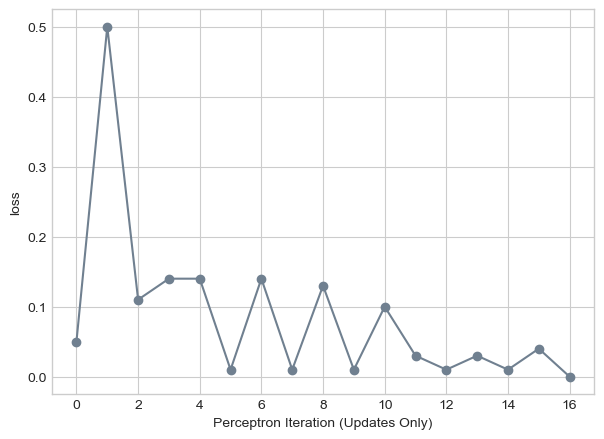

In [127]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Next we with use `k = 10` that can still find a separating line in two dimensions on the same data.

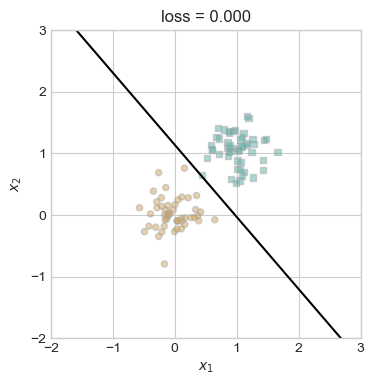

In [128]:
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

k=10

max_iter = 1000
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i, k)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

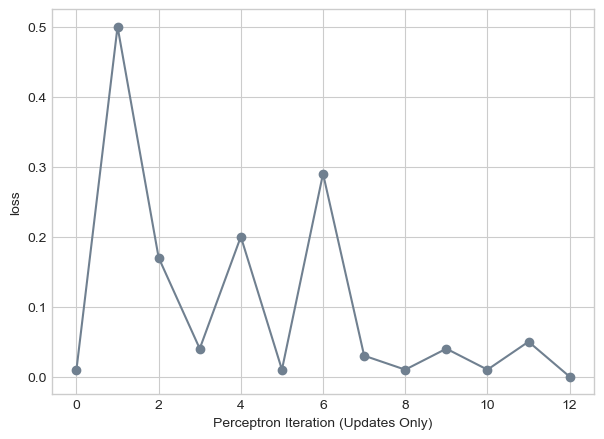

In [129]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Given the same data set having a batch size of `k = 10` increased the number of iterations we needed to find the separating line.

What will our results be when the batch size is our entire dataset? That is `k = n` where `n = 100`. Lets first try it on the same dataset.

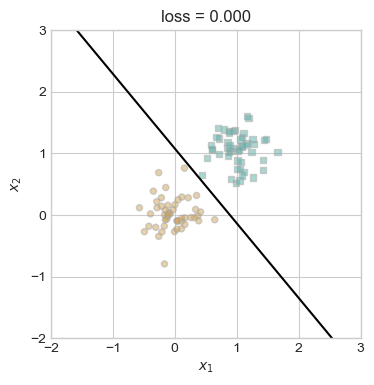

In [130]:
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

k=n

max_iter = 1000
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i, k)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

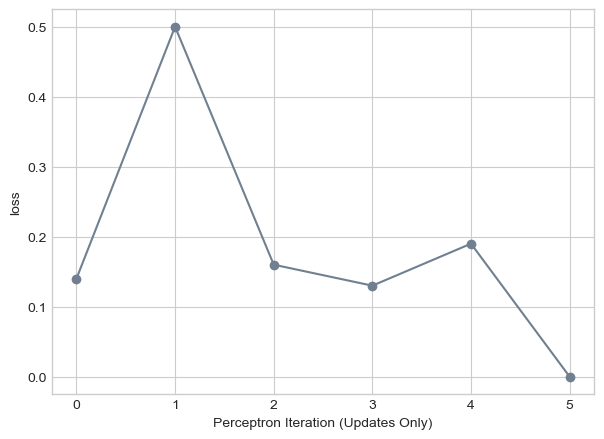

In [131]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We can see that in this case we are able to find the separating line much faster!

Now lets see what we can learn from using mini-batch perceptron on data that is *not linearly separable*. For this we will also tune our learning rate to be `0.01` so we take smaller steps at each iteration.

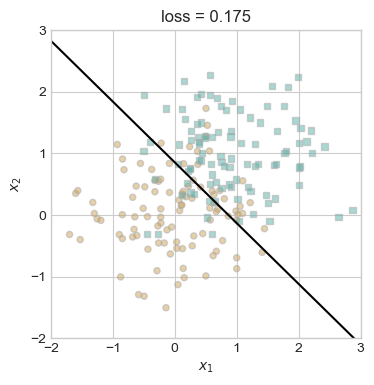

In [132]:
torch.manual_seed(1017)
X, y = perceptron_data(n_points=200, noise=0.7)
n = X.shape[0]

p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

loss_vec = []

k=n
learning_rate = 0.01

max_iter = 1000
loss = 1
while loss > 0 and max_iter > 0:
    i = torch.randint(n, size=(1,))
    x_i = X[[i], :]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()
    
    if local_loss > 0:
        old_w = torch.clone(p.w)
        opt.step(x_i, y_i, k, learning_rate)
        loss = p.loss(X, y).item()
        
        loss_vec.append(loss)

    max_iter -= 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min=-2, x_max=3, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-2, 3), ylim=(-2, 3))
plt.show()

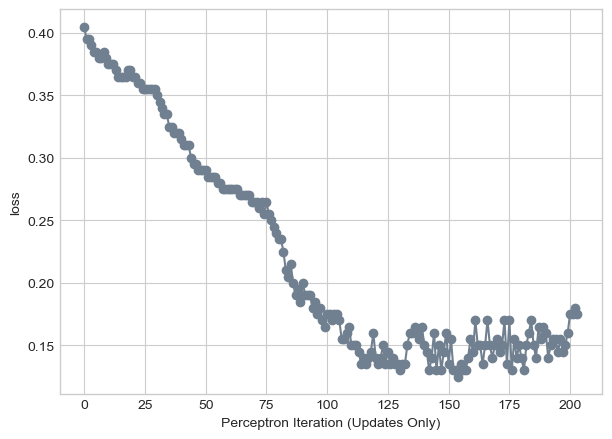

In [133]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

We observe that even with non linearly separable data that the algorithm is still able to converge as we take smaller steps towards a line that fits pretty well!

# Discussion

The runtime complexity of an iteration of the perceptron algorithm is `O(p)`. This comes from doing the dot product in our `.score()` function on a matrix that is size $n \times p$, where $n$ is the number of points and $p$ is the number of features. In addition, updating our weights `w` is the same complexity. This is independent of the number of points $n$.

Based on this, when we do minibatch perceptron, we are doing `k` dot products which would give us `O(kp)`. In some cases this might depend on $n$ as it did in our final example where we set `k = n`. So while mini-batch helps us with non linearly separable data, it comes at the expense of increased time complexity.

# Conclusion

In this post, we implemented the perceptron algorithm and discussed it's inner workings. We also explored the benefits of mini-batch processing that although it's per-iteration complexity is `O(kp)`, can improve convergence characteristics for non linearly separable data. Our experiments on both linearly separable and non-linearly separable datasets highlighted the importance of tuning parameter like batch size and learning rate. Additionally, we showed how perceptron can accurately classify high dimensional data through our experimentation with testing on seven dimensional data. Overall, these findings gave us the conceptual foundations for linear classification and provided a practical roadmap for applying and optimizing perceptron-based models.